In [1]:
#Import libraries
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm
import cPickle

In [2]:
#fil=open('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/measErrs_nobulgedisk_rot0deg.pkl')
fil = open('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/measErrs_diskonly_rot0deg_10000gals.pkl')
res=cPickle.load(fil)
fil.close()


In [3]:
sde1, sde2, hlr, sn, q, ident = res
nanI = np.where(np.isnan(sde1))[0]
assert np.all(nanI == np.where(np.isnan(sde2))[0])
sde1, sde2, hlr, sn, q, ident = [np.delete(i,nanI) for i in res]
ind = range(len(sde1))

0.0 0.010191529989242554


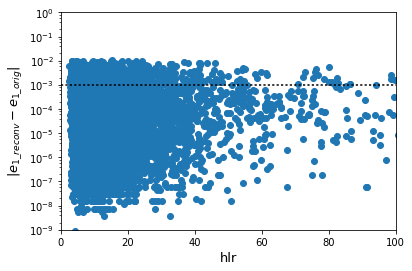

In [4]:
xoptions={'q':q,'hlr':hlr,'sersic_n':sn,'hlr*sqrt(q)':hlr*np.sqrt(q)}
xchoice='hlr'
xarr = xoptions[xchoice]
yarr = sde1
if np.all(yarr==sde1):
    ylabel='$|e_{1\_reconv}-e_{1\_orig}|$'
else:
    ylabel='$|e_{2\_reconv}-e_{2\_orig}|$'
fig,ax=plt.subplots()
plt.scatter(xarr,yarr)
print np.nanmin(yarr),np.nanmax(yarr)
plt.ylim(1e-9,1e-0)
ax.set_yscale('log')
plt.ylabel(ylabel,size=13)
plt.xlabel(xchoice,size=13)
plt.xlim(0,100)
#ax.set_xscale('log')
plt.axhline(1e-3,linestyle=':',c='k')
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/errs_vs_'+xchoice+'.png')

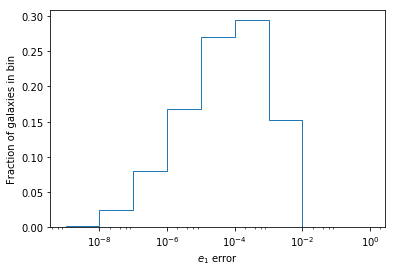

In [5]:
fig,ax=plt.subplots()
arr = yarr
weights = np.ones_like(arr)/float(len(arr))
hist1,bins1,patch=plt.hist(arr, bins=np.logspace(-9,0, 10),histtype='step',weights=weights)
ax.set_xscale('log')
plt.xlabel('$e_1$ error')
plt.ylabel('Fraction of galaxies in bin')
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/e1_err_hist.png')
#ax.set_yscale('log')

In [6]:
cuts = (hlr<100)&(sn<1.5)&(sn>0.5)
hlr0,q0,sde20,sde10,sn0, ident0 = hlr[cuts],q[cuts],sde2[cuts],sde1[cuts], sn[cuts], ident[cuts]

yarr0 = sde10

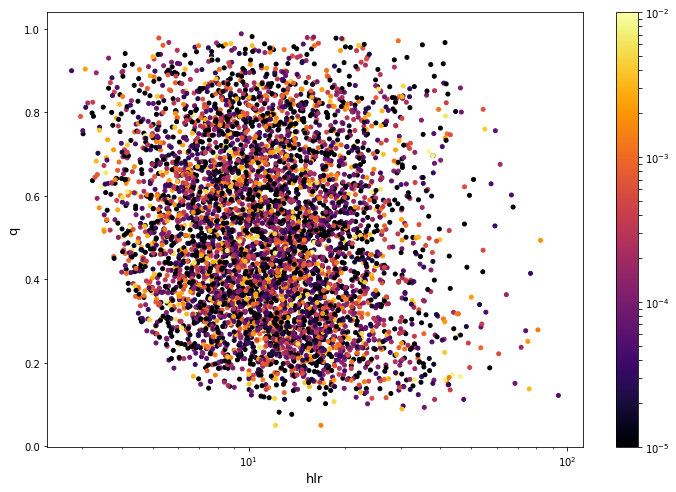

In [7]:
fig,ax=plt.subplots(figsize=(12,8))
plt.scatter(hlr0,q0,c=yarr0,norm=LogNorm(),vmin=1e-5,vmax=1e-2,alpha=1.,cmap=cm.inferno,s=16)
plt.xlabel('hlr',size=13)
plt.ylabel('q',size=13)
ax.set_xscale('log')
plt.colorbar()

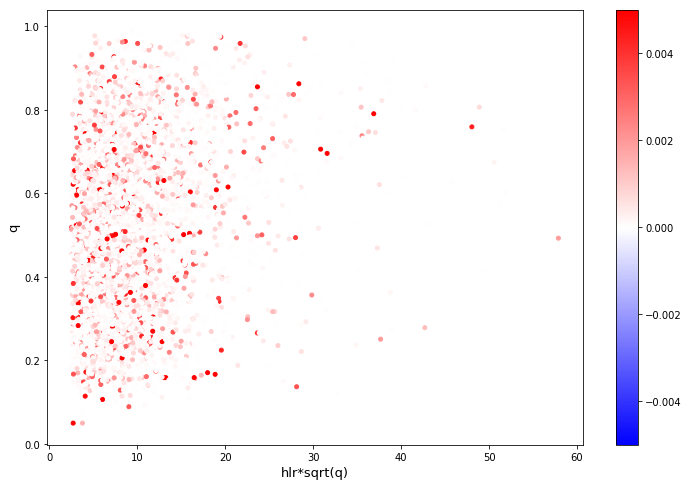

In [8]:
fig,ax=plt.subplots(figsize=(12,8))
#plt.scatter(hlr0*np.sqrt(q0),q0,c=yarr0,norm=LogNorm(),vmin=1e-5,vmax=1e-2,alpha=1.,cmap=cm.inferno,s=16)
vmax=5e-3
plt.scatter(hlr0*np.sqrt(q0),q0,c=yarr0,alpha=1., vmin=-vmax,vmax=vmax,cmap=cm.bwr,s=16)

plt.xlabel('hlr*sqrt(q)',size=13)
plt.ylabel('q',size=13)
#ax.set_xscale('log')
#plt.xlim(25,30)
#plt.ylim(0.85,1.)
plt.colorbar()

In [9]:
badGals = (sde10>5e-3) & (hlr0*np.sqrt(q0)>30)
identBad = ident0[badGals]

In [10]:
print identBad

[ 164666  196679 1201847]


In [11]:
#gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=9.e-4)
gsparams = galsim.GSParams(maximum_fft_size=2048*10)

cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
identifiers = cc.param_cat['IDENT']
galsIndex = np.array([np.where(identifiers == bad)[0][0] for bad in identBad])
gals = cc.makeGalaxy(galsIndex, chromatic=False,gsparams=gsparams)
sersicparams = cc.param_cat['sersicfit']
hlr,n,q = sersicparams[:,1], sersicparams[:,2], sersicparams[:,3]
hlrbad, nbad, qbad = hlr[galsIndex], n[galsIndex], q[galsIndex]
sde1bad = sde10[badGals]

In [12]:
print galsIndex

[ 8316  9264 10042]


In [78]:
def removeBulge(gal):
    if type(gal) != galsim.compound.Sum:
        return gal
    else:
        disk = gal.obj_list[1]
        return disk

for i in range(len(identBad)):
    gals[i] = removeBulge(gals[i])

In [79]:
params= zip(np.round(hlrbad,2),np.round(nbad,2),np.round(qbad,2),np.round(sde1bad,4))
print params

[(41.48, 0.9, 0.79, 0.0064), (36.72, 0.93, 0.71, 0.0086), (37.86, 1.32, 0.7, 0.0077)]


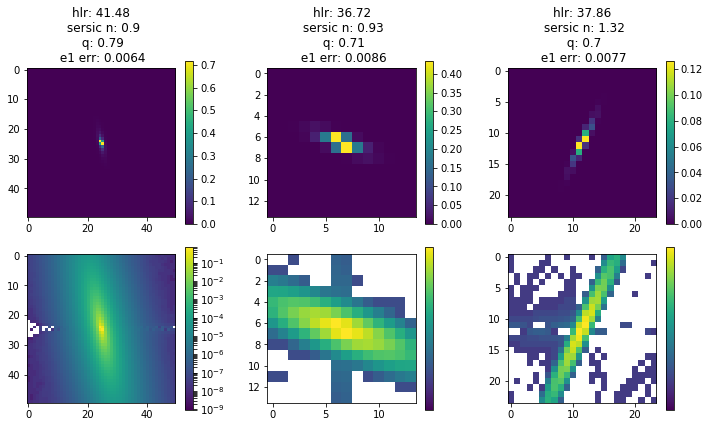

In [81]:
from matplotlib.colors import LogNorm
pixel_scale = 0.1
fig,ax = plt.subplots(2,3,figsize=(10,6))
for i,gal in enumerate(gals):
    im = gal.drawImage(scale = pixel_scale/2.)
    a0=ax[0,i].imshow(im.array)
    a1=ax[1,i].imshow(im.array, norm=LogNorm())
    fig.colorbar(a0,ax=ax[0,i])
    fig.colorbar(a1,ax=ax[1,i])
    ax[0,i].set_title('hlr: %s\n sersic n: %s\n q: %s\n e1 err: %s' % (params[i]))
plt.tight_layout()
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/badgalaxies.png')

[(41.48, 0.9, 0.79), (36.72, 0.93, 0.71), (37.86, 1.32, 0.7)]


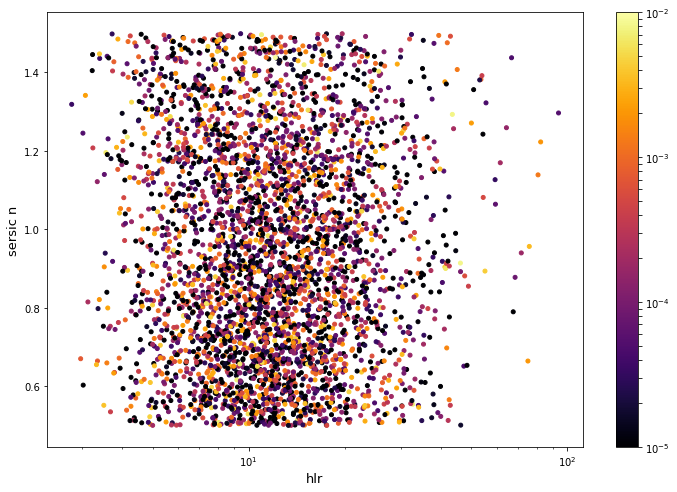

In [9]:
fig,ax=plt.subplots(figsize=(12,8))
plt.scatter(hlr0,sn0,c=yarr0,norm=LogNorm(),vmin=1e-5,vmax=1e-2,alpha=1.,cmap=cm.inferno,s=16)
plt.xlabel('hlr',size=13)
plt.ylabel('sersic n',size=13)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.colorbar()

(array([2482., 1576.,  883.,  524.,  327.,  285.,  231.,  186.,  175.,
         537.]),
 array([0.50003697, 1.05003328, 1.60002958, 2.15002588, 2.70002218,
        3.25001849, 3.80001479, 4.35001109, 4.90000739, 5.4500037 ,
        6.        ]),
 <a list of 10 Patch objects>)

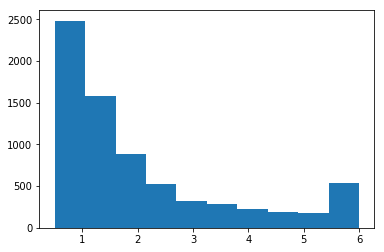

In [10]:
plt.hist(sn)

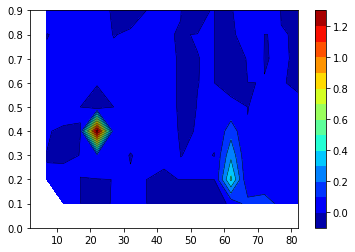

In [124]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
x,y = hlr0, q0
z = sde20

xi = np.arange(2,87,5)
yi = np.arange(0.0,1,0.1)
# grid the data.
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
#plt.scatter(x,y,marker='o',c='b',s=5)
plt.show()


In [146]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# cut=sde2>1e-3
# ax.scatter(sn[cut],q[cut],np.log10(sde1[cut]),c='b')
# ax.scatter(sn[~cut],q[~cut],np.log10(sde1[~cut]),c='r')

# ax.set_xlim(0,100)


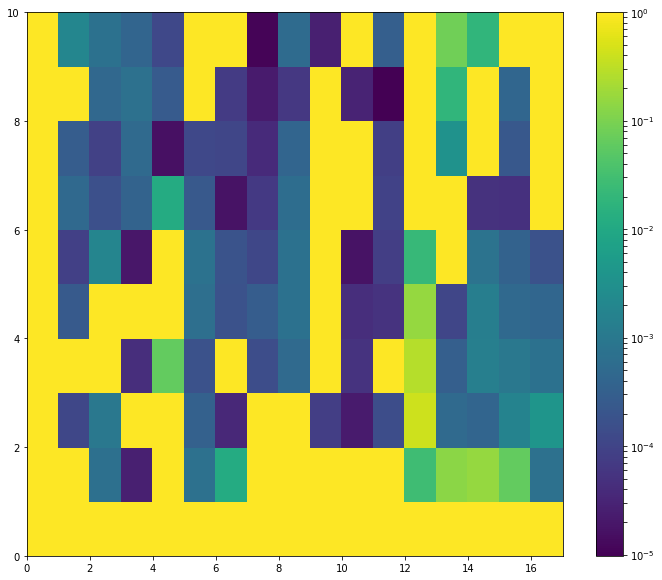

In [126]:
fig = plt.figure(figsize=(12,10))
zi[np.isnan(zi)] = 1000
zi[zi<=0] = 1000
plt.pcolormesh(zi,norm=LogNorm(),vmax=1)
plt.colorbar()